In [1]:
# Import Packages
import numpy as np
from torch.autograd import Variable
import torch
from tqdm import tqdm
import matplotlib.pyplot as plt
%matplotlib inline

import os
os.environ["KMP_DUPLICATE_LIB_OK"] = "True"

# Import local model files
from FBRN.myfunc import Physics
from FBRN.myfunc import MyMatmul
from FBRN.main import FBRestNet
from FBRN.model import MyModel
from FBRN.myfunc import Export_hyper

from FBRN.proxop.hypercube import cardan
from FBRN.proxop.hyperslab import cardan_slab

In [24]:
# Model parameters
params = {
    'N' : 2000,
    'k' : 50,
    'a' : 1,
    'r' : 1

}

In [48]:
m=params['k']
nx=params['N']
a=params['a']

eigm = (np.linspace(0,m-1,m)+1/2)*np.pi
eig_m      = eigm.reshape(-1,1)
# Fix the base definition
#v1         = ((2*np.linspace(0,self.nx-1,self.nx)+1)*h/2).reshape(1,-1)
v1         = ((2*np.linspace(0,nx-1,nx)+1)/(2*nx)).reshape(1,-1)
# we consider base[i](nx) = 0, then v1[nx] = 1. And v1[0] = 0.
#v1         = ((2*np.linspace(0,nx-1,nx))/(2*nx)).reshape(1,-1)
#v2         = (np.ones(self.nx)/2*h).reshape(1,-1)
v2         = (np.ones(nx)/(2*nx)).reshape(1,-1)

#### OBSERVATION: The base differs from the theory on the paper!!!

In [49]:
base       = 2*np.sqrt(2)/eig_m*np.cos(v1*eig_m)*np.sin(v2*eig_m)
#base       = 2*np.sqrt(2)*np.tile(eig_m**(-a),(1,nx))*np.cos(v1*(eig_m**(a)))*np.sin(v2*eig_m**(a))

### Is the base orthogonal?

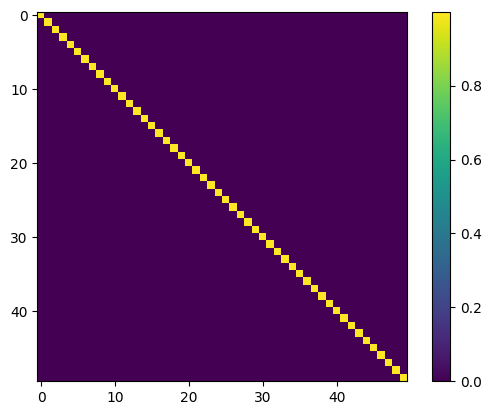

In [50]:
cross_prod =  np.zeros((params['k'],params['k']))

for i in range(params['k']):
    for j in range(params['k']):
        cross_prod[i,j] = base[i].T@base[j]*params['N']

plt.imshow(cross_prod)
plt.colorbar()
plt.show()

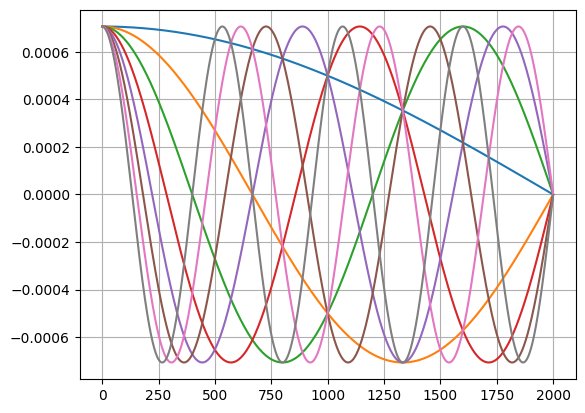

In [51]:
for i in range(8): 
    plt.plot(base[i])
plt.grid(True,'both')

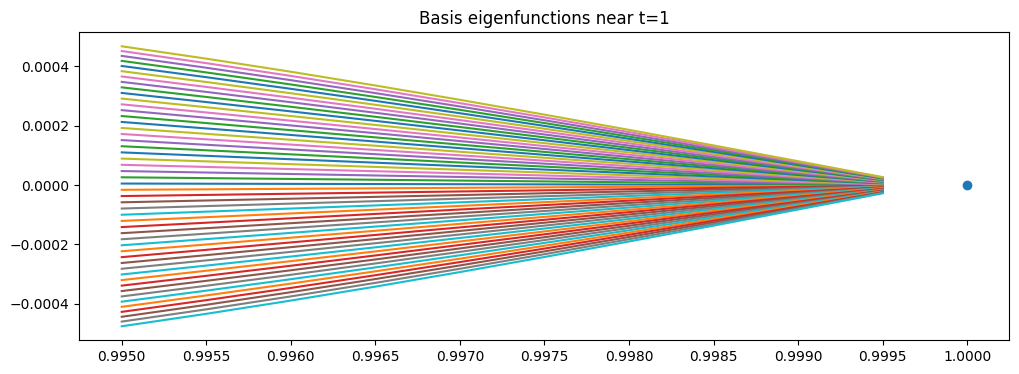

In [52]:
t = np.linspace(0,(params['N']-1)/params['N'],params['N'])
plt.figure(figsize=(12,4))
for func in base:
    plt.plot(t[params['N']-10:], func[params['N']-10:])

plt.plot(1,0, marker='o')
plt.xticks(t[params['N']-11:]+t[1])
plt.title('Basis eigenfunctions near t=1')
plt.show()

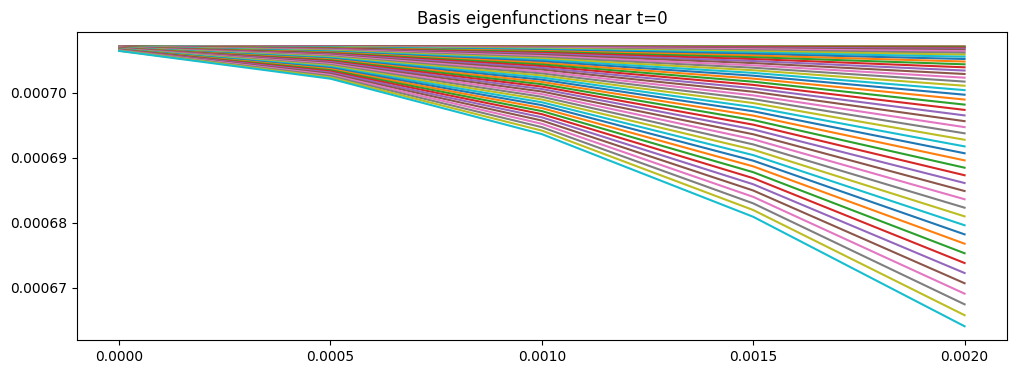

In [53]:

plt.figure(figsize=(12,4))
for func in base:
    plt.plot(t[:5], func[:5])

#plt.plot(1,0, marker='o')
plt.xticks(t[:5])
plt.title('Basis eigenfunctions near t=0')
plt.show()

# Create Model

In [54]:
# Model
model = FBRestNet(
    experimentation=Physics(params['N'],params['k'],params['a'],params['r']), constraint = 'cube', nb_blocks=20, noise = 0.05,
    folder = './../', im_set="Set1",batch_size=[600,1],lr=1e-3, nb_epochs=[30,1], loss_elt=False, save=False
)

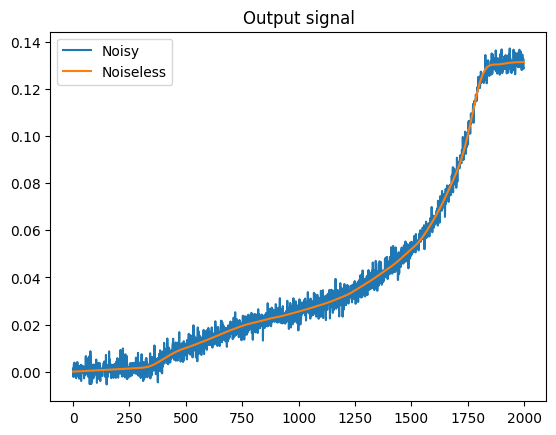

In [55]:
# Generate dataset
train_set, val_set = model.CreateDataSet()

In [58]:
# Select one signal
signal_id = 13
[y,x] = val_set.dataset[signal_id:signal_id+1]
x_true = Variable(x, requires_grad=False)
x_bias = Variable(y, requires_grad=False)

# Test the basis change

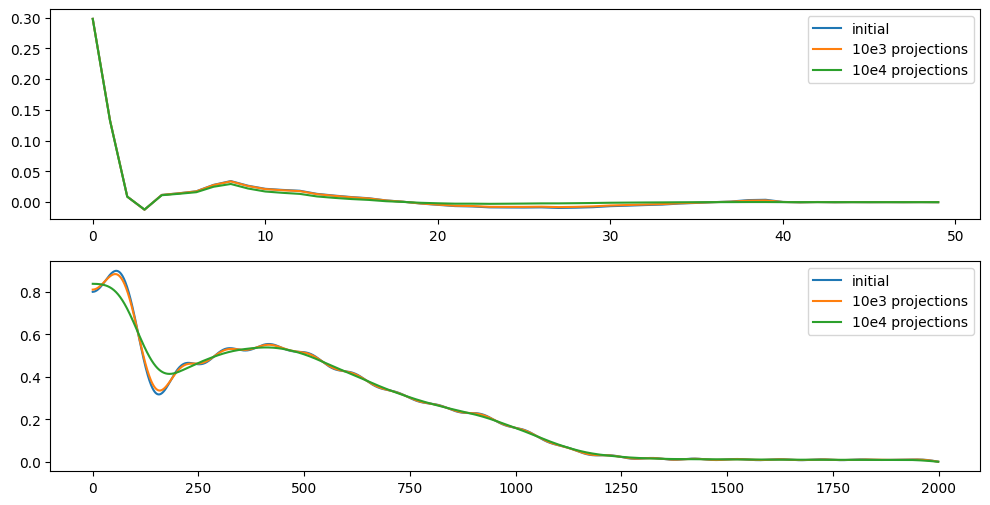

In [59]:
fig, ax = plt.subplots(2,1,figsize=(12,6))

ax[0].plot(x_true.numpy()[0,0], label='initial')
x_true_elt = model.physics.BasisChangeInv(x_true)
ax[1].plot(x_true_elt.numpy()[0,0], label='initial')

for i in range(10000):
    x_true_hat = model.physics.BasisChange(x_true_elt)
    x_true_elt = model.physics.BasisChangeInv(x_true_hat)
    if i == 1000:
        ax[0].plot(x_true_hat.numpy()[0,0], label='10e3 projections')
        ax[1].plot(x_true_elt.numpy()[0,0], label='10e3 projections')

ax[0].plot(x_true_hat.numpy()[0,0], label='10e4 projections')
ax[1].plot(x_true_elt.numpy()[0,0], label='10e4 projections')
ax[0].legend()
ax[1].legend()
plt.show()
